In [ ]:
# import statements

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# make plots a bit nicer
plt.style.use("default")
sns.set(font_scale=1.0)
%matplotlib inline

In [ ]:
# import df

df = pd.read_csv('/content/spotify_churn_dataset.csv')

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

display(df.head())

Shape: (8000, 12)

Columns: ['user_id', 'gender', 'age', 'country', 'subscription_type', 'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type', 'ads_listened_per_week', 'offline_listening', 'is_churned']


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [ ]:
# general dataset desriptions and exploratory analysis

print("----- Info -----")
df.info()

print()
print("\n----- Missing values per column -----")
print(df.isna().sum())

print()
print("\n----- Duplicate rows -----")
num_dups = df.duplicated().sum()
print("Number of duplicate rows:", num_dups)

print()
print("\n----- Target distribution (is_churned) -----")
print(df["is_churned"].value_counts(normalize=True).rename("proportion"))

----- Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


----- Missing values per column -----
user_id                  0
gender           

In [ ]:
df_clean = df.copy()

# drop duplicates
print("Rows before dropping duplicates:", df_clean.shape[0])
df_clean = df_clean.drop_duplicates()
print("Rows after dropping duplicates: ", df_clean.shape[0])

# check if there is currently missing values
print("\nMissing values after cleaning:")
print(df_clean.isna().sum())


Rows before dropping duplicates: 8000
Rows after dropping duplicates:  8000

Missing values after cleaning:
user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64


Numeric columns used for histograms: ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'offline_listening']


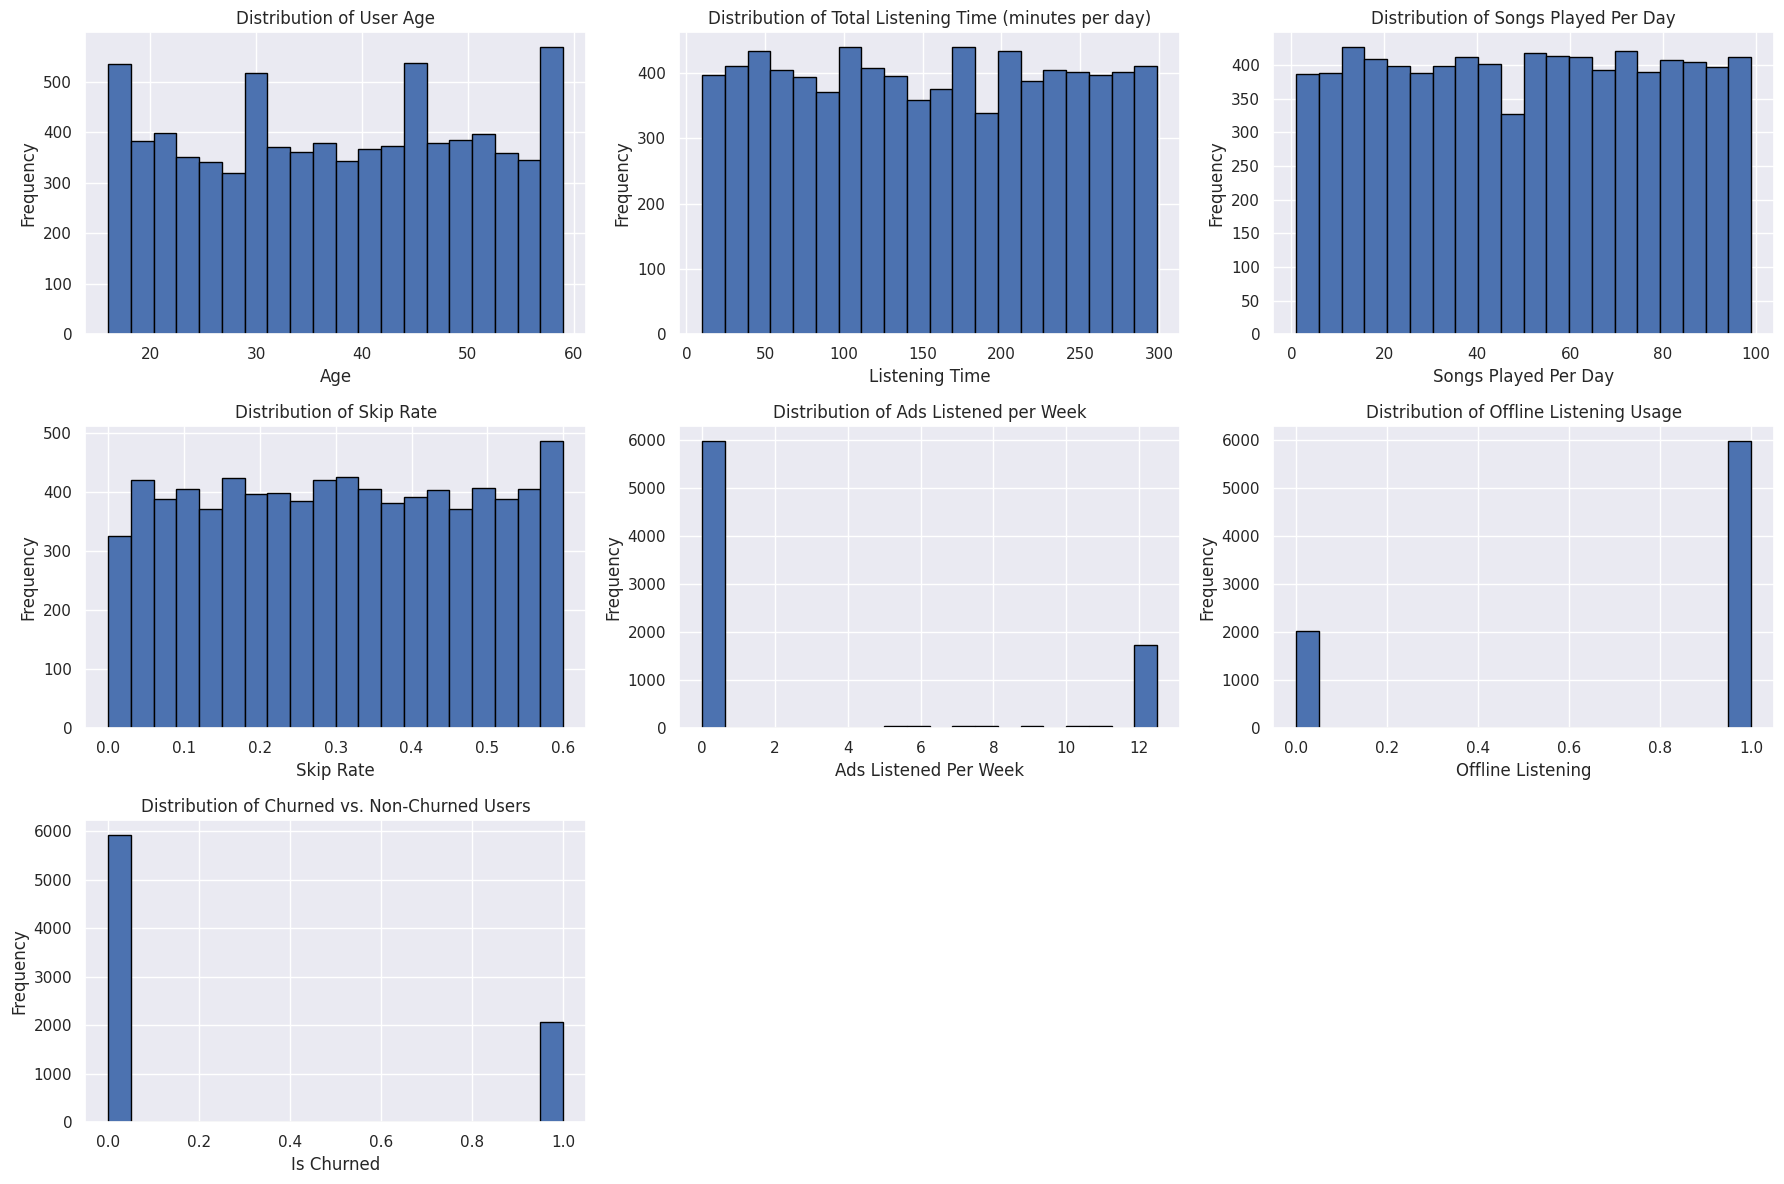

In [ ]:
# Histograms with improved descriptive titles

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c not in ["is_churned", "user_id"]]

print("Numeric columns used for histograms:", numeric_cols_no_target)

# Mapping variable names → nicer titles
title_map = {
    "age": "Distribution of User Age",
    "listening_time": "Distribution of Total Listening Time (minutes per day)",
    "songs_played_per_day": "Distribution of Songs Played Per Day",
    "skip_rate": "Distribution of Skip Rate",
    "ads_listened_per_week": "Distribution of Ads Listened per Week",
    "offline_listening": "Distribution of Offline Listening Usage",
    "is_churned": "Distribution of Churned vs. Non-Churned Users"
}

# Create subplot grid
all_cols = numeric_cols_no_target + ["is_churned"]
num_plots = len(all_cols)
cols = 3
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    df_clean[col].plot(
        kind="hist",
        bins=20,
        edgecolor="black",
        ax=axes[i],
        title=title_map.get(col, col)
    )
    axes[i].set_xlabel(col.replace("_", " ").title())   # prettier x-labels
    axes[i].set_ylabel("Frequency")

# Hide unused subplot slots
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Numeric columns used for boxplots: ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'offline_listening']


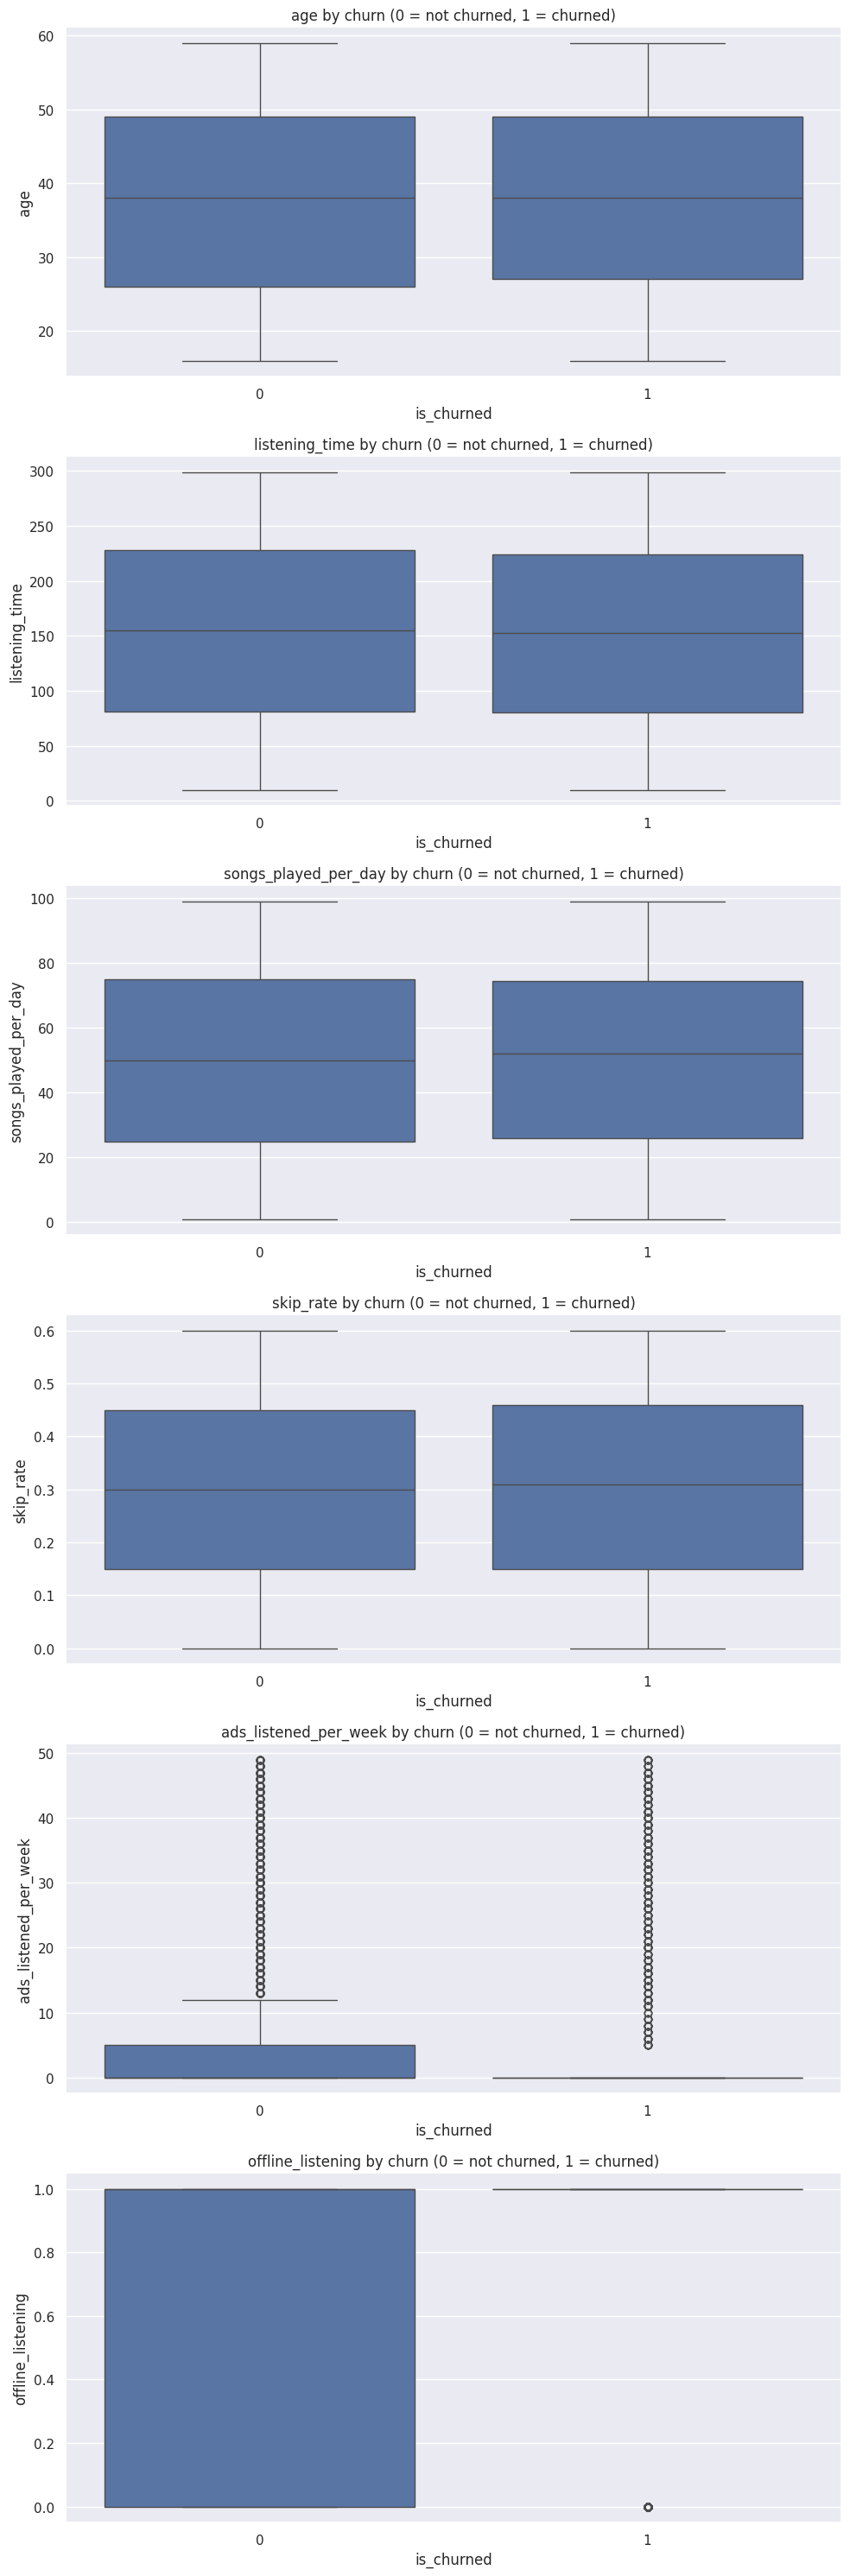

In [ ]:
# boxplots

# recompute numeric columns (fresh)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# remove target and user_id
numeric_cols_no_target = [c for c in numeric_cols if c not in ["is_churned", "user_id"]]

print("Numeric columns used for boxplots:", numeric_cols_no_target)

# create subplots
fig, axes = plt.subplots(
    nrows=len(numeric_cols_no_target),
    ncols=1,
    figsize=(10, 5 * len(numeric_cols_no_target))
)

# If only one numeric column, axes won't be a list, so fixing that
if len(numeric_cols_no_target) == 1:
    axes = [axes]

for ax, col in zip(axes, numeric_cols_no_target):
    sns.boxplot(
        data=df_clean,
        x="is_churned",
        y=col,
        ax=ax
    )
    ax.set_title(f"{col} by churn (0 = not churned, 1 = churned)")
    ax.set_xlabel("is_churned")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


In [ ]:
# testing changes in histogram and boxplots after clipping outliers for numeric features

# first clip outliers

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()

# remove target and user_id
numeric_cols_no_target = [c for c in numeric_cols if c not in ["is_churned", "user_id"]]

for col in numeric_cols_no_target:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip values to the bounds
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

print("Outlier clipping completed for numeric features.")

Outlier clipping completed for numeric features.


Numeric columns used for histograms: ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'offline_listening']


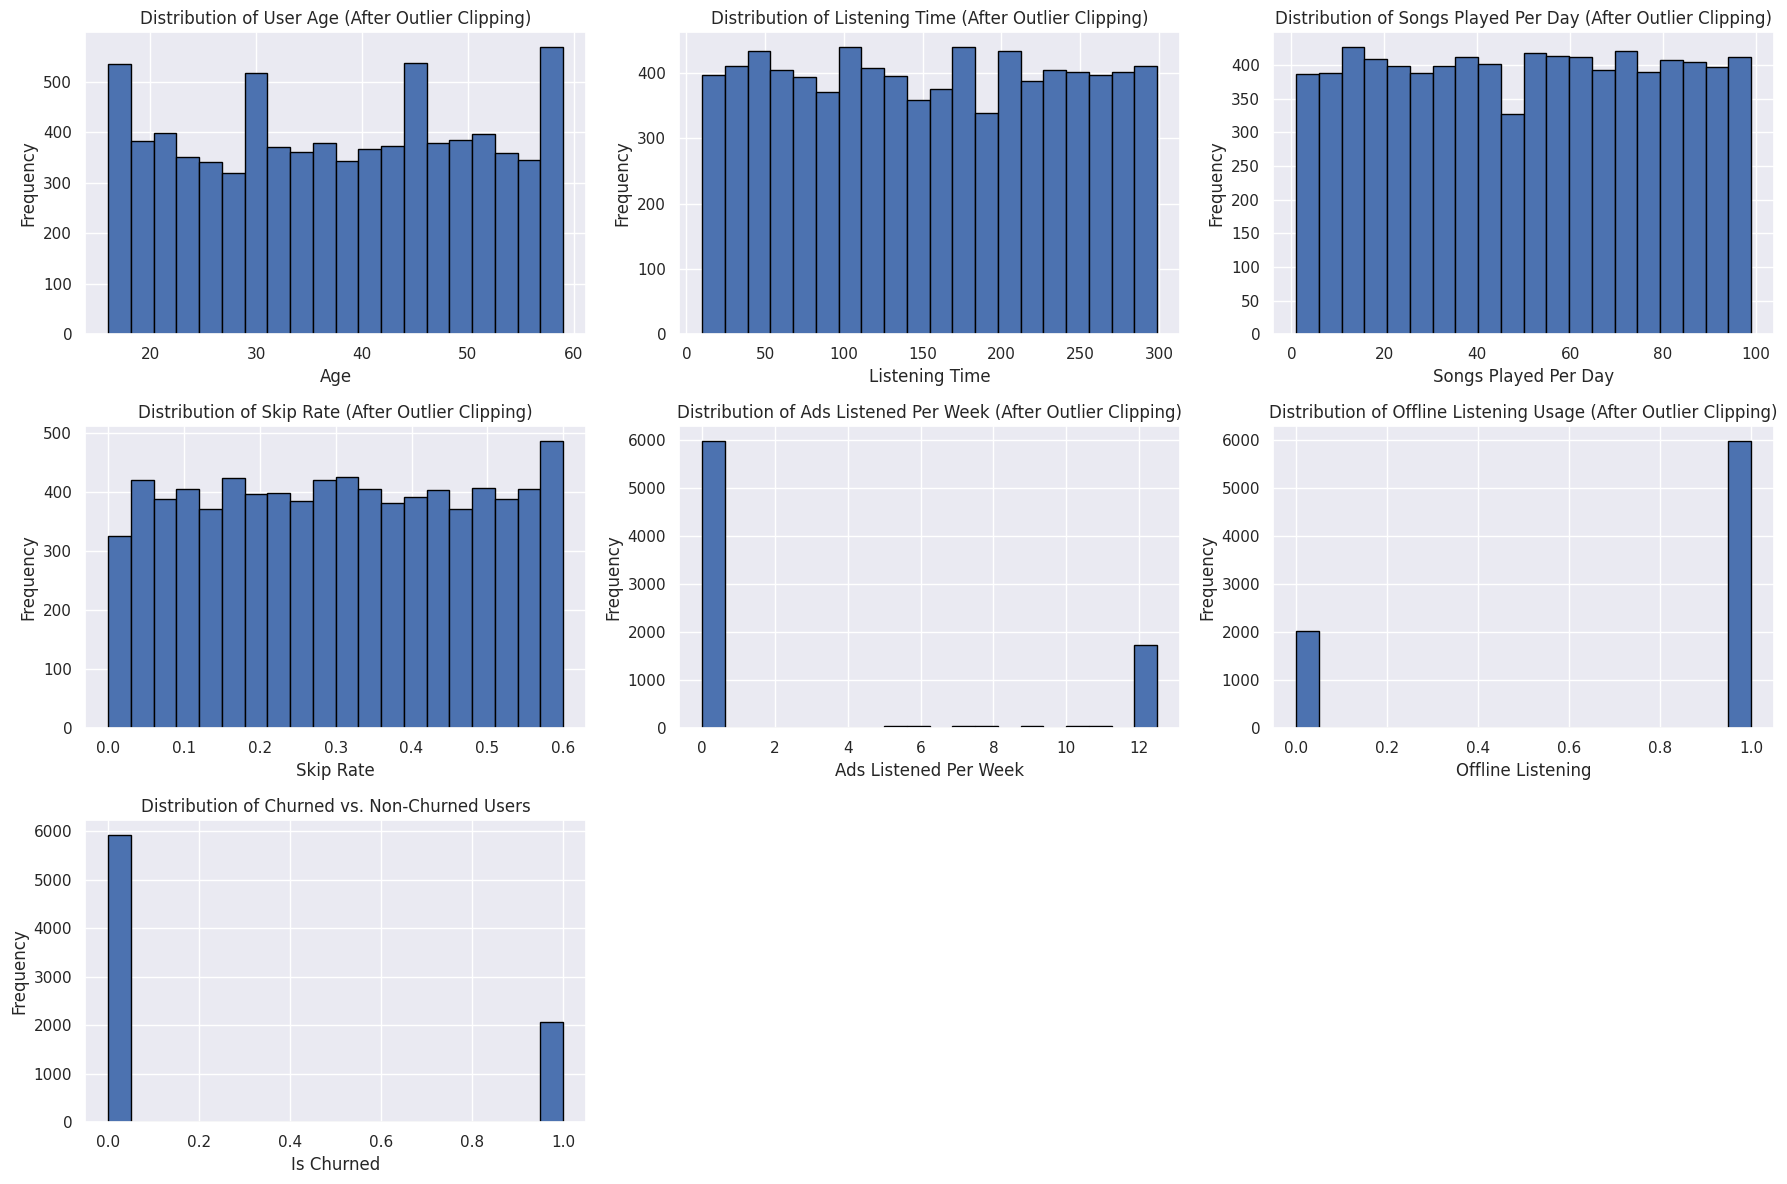

In [ ]:
# Retesting histograms with descriptive titles (after outlier clipping)

# Recompute numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c not in ["is_churned", "user_id"]]

print("Numeric columns used for histograms:", numeric_cols_no_target)

# Descriptive titles for each variable
title_map = {
    "age": "Distribution of User Age (After Outlier Clipping)",
    "listening_time": "Distribution of Listening Time (After Outlier Clipping)",
    "songs_played_per_day": "Distribution of Songs Played Per Day (After Outlier Clipping)",
    "skip_rate": "Distribution of Skip Rate (After Outlier Clipping)",
    "ads_listened_per_week": "Distribution of Ads Listened Per Week (After Outlier Clipping)",
    "offline_listening": "Distribution of Offline Listening Usage (After Outlier Clipping)",
    "is_churned": "Distribution of Churned vs. Non-Churned Users"
}

# Create subplot grid
all_cols = numeric_cols_no_target + ["is_churned"]
num_plots = len(all_cols)
cols = 3
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Plot each histogram with title + labels
for i, col in enumerate(all_cols):
    df_clean[col].plot(
        kind="hist",
        bins=20,
        edgecolor="black",
        ax=axes[i],
        title=title_map.get(col, f"{col} (After Outlier Clipping)")
    )
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel("Frequency")

# Remove empty subplot panels
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


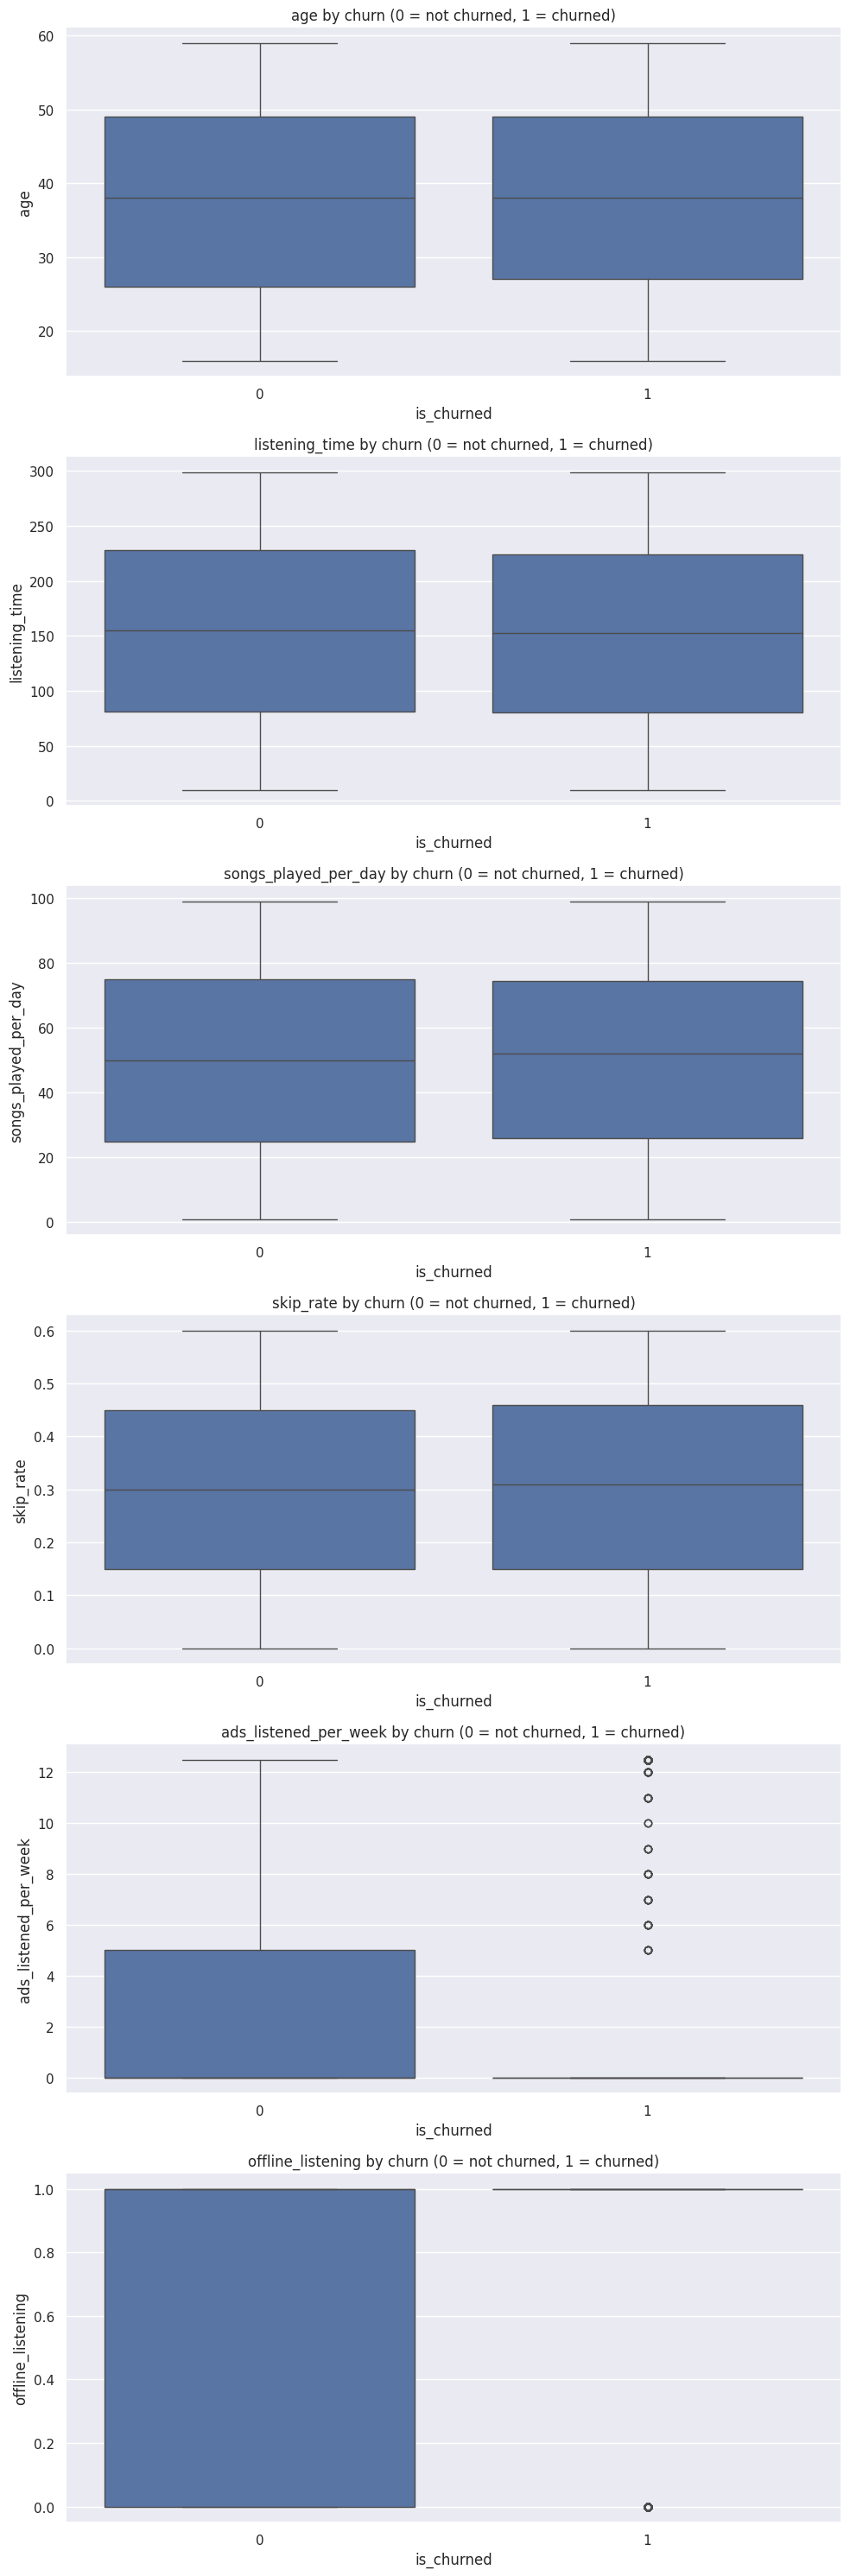

In [ ]:
# boxplots post using outlier clipping

fig, axes = plt.subplots(
    nrows=len(numeric_cols_no_target),
    ncols=1,
    figsize=(10, 5 * len(numeric_cols_no_target))
)

if len(numeric_cols_no_target) == 1:
    axes = [axes]  # Make iterable if only one numeric col

for ax, col in zip(axes, numeric_cols_no_target):
    sns.boxplot(
        data=df_clean,
        x="is_churned",
        y=col,
        ax=ax
    )
    ax.set_title(f"{col} by churn (0 = not churned, 1 = churned)")
    ax.set_xlabel("is_churned")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


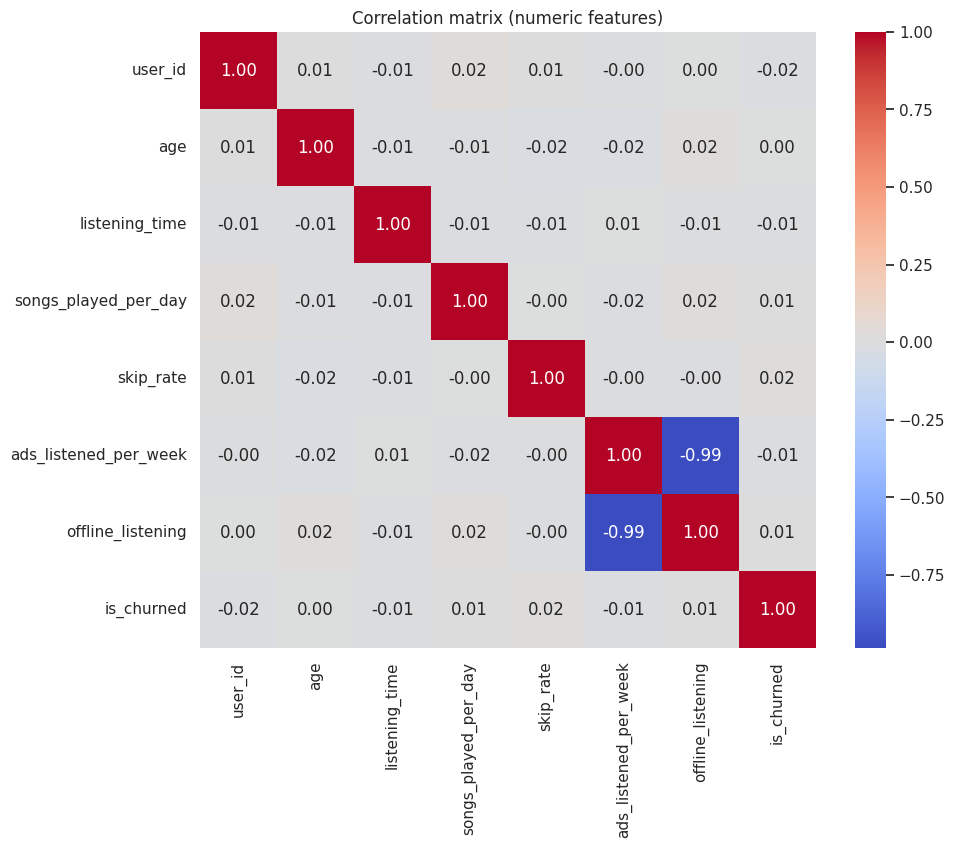

Top correlations with churn:
is_churned               1.000000
skip_rate                0.016121
offline_listening        0.012754
songs_played_per_day     0.009314
age                      0.003982
listening_time          -0.007624
ads_listened_per_week   -0.009849
user_id                 -0.015994
Name: is_churned, dtype: float64


In [ ]:
# correlation heatmap

corr = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation matrix (numeric features)")
plt.show()

print("Top correlations with churn:")
print(corr["is_churned"].sort_values(ascending=False))


subscription_type
Premium    2115
Free       2018
Student    1959
Family     1908
Name: count, dtype: int64

Subscribed flag value counts:
subscribed_flag
1    5982
0    2018
Name: count, dtype: int64

Unsubscribed shape: (2018, 13)
Subscribed shape:   (5982, 13)

Churn rate by subscription_type:
subscription_type
Family     0.275157
Free       0.249257
Premium    0.250591
Student    0.261868
Name: is_churned, dtype: float64


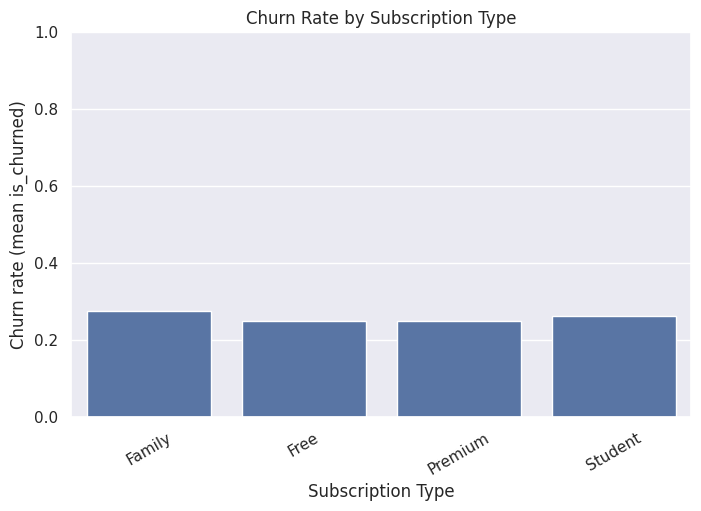


Churn rate by subscribed_flag (0=Free, 1=Paid type):
subscribed_flag
0    0.249257
1    0.262120
Name: is_churned, dtype: float64


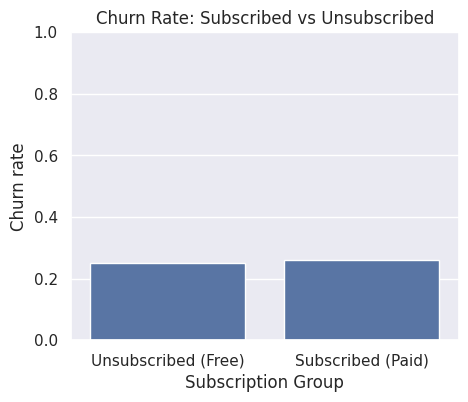

In [ ]:
# create subscribed_flag and compare churn

# Create a binary flag: 1 = subscribed (non-free), 0 = unsubscribed (Free)
df_clean["subscribed_flag"] = np.where(
    df_clean["subscription_type"] == "Free",
    0,
    1
)

print(df_clean["subscription_type"].value_counts())
print("\nSubscribed flag value counts:")
print(df_clean["subscribed_flag"].value_counts())

# split into two dataframes
df_unsubscribed = df_clean[df_clean["subscribed_flag"] == 0]
df_subscribed   = df_clean[df_clean["subscribed_flag"] == 1]

print("\nUnsubscribed shape:", df_unsubscribed.shape)
print("Subscribed shape:  ", df_subscribed.shape)

# compare churn rate by subscription_type
churn_by_sub_type = df_clean.groupby("subscription_type")["is_churned"].mean()

print("\nChurn rate by subscription_type:")
print(churn_by_sub_type)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=churn_by_sub_type.index,
    y=churn_by_sub_type.values
)
plt.ylabel("Churn rate (mean is_churned)")
plt.xlabel("Subscription Type")
plt.title("Churn Rate by Subscription Type")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.show()

# compare churn rate for subscribed vs unsubscribed
churn_by_subscribed_flag = df_clean.groupby("subscribed_flag")["is_churned"].mean()

print("\nChurn rate by subscribed_flag (0=Free, 1=Paid type):")
print(churn_by_subscribed_flag)

plt.figure(figsize=(5, 4))
sns.barplot(
    x=churn_by_subscribed_flag.index.astype(str),
    y=churn_by_subscribed_flag.values
)
plt.xticks([0, 1], ["Unsubscribed (Free)", "Subscribed (Paid)"])
plt.ylabel("Churn rate")
plt.xlabel("Subscription Group")
plt.title("Churn Rate: Subscribed vs Unsubscribed")
plt.ylim(0, 1)
plt.show()


#Results

The exploratory data analysis revealed that most user behavior metrics **do not differ substantially between churned and non-churned users.** Histograms and boxplots showed that age, listening time, songs played per day, and skip rate have very similar distributions across both groups. The correlation matrix confirmed this, with all numerical features exhibiting extremely weak correlations with churn (absolute values less than 0.02). This indicates that no single numeric variable in the dataset strongly predicts churn on its own.

**The only variable showing a noticeable pattern was subscription type.** While the differences were small, churn was slightly higher among Family (27.5%) and Student (26.2%) plans, compared to Premium (25.1%) and Free (24.9%) users. When simplified into “Subscribed (Paid)” vs “Unsubscribed (Free),” churn remained relatively close—26.2% for paid users and 24.9% for free users. This suggests that subscription status may play a modest role, but it is not a strong predictor by itself.

Overall, the dataset appears clean, with minimal missing values and no extreme outliers that required removal. The distributions of behavioral features are realistic and consistent with typical streaming habits.



#Conclusion
the EDA highlights patterns in user behavior and subscription type, the current feature set provides limited predictive power for understanding churn. Further data collection or feature engineering would be essential to improve churn modeling and generate actionable insights for retention strategies.